In [1]:
# library imports
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, LinearRegression

# just for jupyter notebooks plot size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
# helper function, generate lagged datasets for testing on vintages
def gen_lagged_data(metadata, data, last_date, lag):
    # only go up to the last date
    lagged_data = data.loc[data.date <= last_date, :].reset_index(drop=True)
    for col in lagged_data.columns[1:]:
        pub_lag = metadata.loc[metadata.series == col, "months_lag"].values[0] # publication lag of this particular variable
        # go back as far as needed for the pub_lag of the variable, then + the lag (so -2 for 2 months back), also -1 because 0 lag means in month, last month data available, not current month in
        lagged_data.loc[(len(lagged_data) - pub_lag + lag - 1) :, col] = np.nan

    return lagged_data

# helper function, flatten a dataset for methods that don't do timeseries, extra columns for each lag
def flatten_data(data, target_variable, n_lags):
    flattened_data = data.loc[~pd.isna(data[target_variable]), :]
    orig_index = flattened_data.index
    for i in range(1, n_lags + 1):
        lagged_indices = orig_index - i
        lagged_indices = lagged_indices[lagged_indices >= 0]
        tmp = data.loc[lagged_indices, :]
        tmp.date = tmp.date + pd.DateOffset(months=i)
        tmp = tmp.drop([target_variable], axis=1)
        tmp.columns = [j + "_" + str(i) if j != "date" else j for j in tmp.columns]
        flattened_data = flattened_data.merge(tmp, how="left", on="date")

    return flattened_data

# helper function fill missings in a dataset with the mean from the training set
def mean_fill_dataset(training, test):
    mean_dict = {}
    for col in training.columns[1:]:
        mean_dict[col] = np.nanmean(training[col])
    filled = test.copy()
    for col in training.columns[1:]:
        filled.loc[pd.isna(filled[col]), col] = mean_dict[col]
    return filled

# Data set up

In [3]:
# data read
metadata = pd.read_csv("../data/russian_meta_data.csv")

# usual method
# data = pd.read_csv("../data/russian_data_tf.csv", parse_dates=["date"])

# distillation from LSTM
# step 0 (usual destillation from LSTM)
# data = pd.read_csv("../data/russian_LSTM_predictions+rest_train.csv", parse_dates=["date"])
# step 1 (mean of real and forecasted)
# data = pd.read_csv("../data/russian_LSTM_predictions_step1.csv", parse_dates=["date"])
# step 2 (mean of real and forecasted)
# data = pd.read_csv("../data/russian_LSTM_predictions_step2.csv", parse_dates=["date"])

# distillation from GB
# step 0 (usual destillation from GB)
# data = pd.read_csv("../data/russian_GB_predictions_distillation.csv", parse_dates=["date"])
# step 1 (mean of real and forecasted) (from GB)
# data = pd.read_csv("../data/russian_GB_predictions_step1.csv", parse_dates=["date"])
# step 2 (mean of real and forecasted for otliers - where big errors)
data = pd.read_csv("../data/russian_GB_predictions_step2.csv", parse_dates=["date"])


# target variable = gdp
target_variable = "gdp"

# which artificial lags to test the model on, equivalent to number of months ahead of and behind the target date (e.g. 2020-06-01 for Q2 2020)
lags = list(range(-2, 3))

# train and test dates
train_start_date = "2004-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2023-12-01"

# train and test datasets
train = data.loc[(data.date >= train_start_date) & (data.date <= train_end_date), :].reset_index(drop=True)
test = data.loc[(data.date >= train_start_date) & (data.date <= test_end_date), :].reset_index(drop=True) # let test set data begin from training begin, data lag/time series for test sets can go back into the training data

Data should be a dataframe of seasonally adjusted growth rates with months in rows and quarterly variables in the last month of the quarter, with `np.nan`s for interquarter months.

In [32]:
data.tail()

,date,ibved,cpi,oil_price,rate,exchange_rate,m2,us_cpi,PMI,unemployment,gdp
237,2023-10-01,-0.003476,0.007528,-0.050174,0.056536,0.018606,0.007443,0.006135,-0.020110,-0.042565,NaN
238,2023-11-01,-0.002770,0.008603,-0.054758,0.138056,-0.071001,0.016074,0.000000,-0.022388,-0.000486,NaN
239,2023-12-01,0.009221,0.004878,-0.016119,0.031674,0.014419,0.013206,0.000000,0.062977,0.017713,0.015419
240,2024-01-01,-0.006672,0.005015,-0.004557,0.033918,-0.000310,0.014697,0.006098,-0.010772,-0.038277,NaN
241,2024-02-01,NaN,0.004907,0.022936,0.000000,0.011464,0.017927,0.000000,-0.052632,NaN,NaN


# Training the model

In [4]:
transformed_train = mean_fill_dataset(train, train) # fill any missing values with the mean
transformed_train = flatten_data(transformed_train, target_variable, 3) # 3 means include 3 additional lags of each variable
# only keep quarterly observations and drop early observations with not enough history for lagged variables
transformed_train = transformed_train.loc[transformed_train.date.dt.month.isin([3,6,9,12]),:].dropna(axis=0, how="any").reset_index(drop=True)

# we can see that e.g. the variable `payems` now has 4 columns in the data, for each of the lags, and that the data now has one row per quarter
transformed_train.loc[:, [True] + list(transformed_train.columns[1:].str.contains("cpi"))].tail()

,date,cpi,us_cpi,cpi_1,us_cpi_1,cpi_2,us_cpi_2,cpi_3,us_cpi_3
50,2016-12-01,0.002119,0.000000,0.003449,0.0,0.004306,0.007812,0.004201,0.000000
51,2017-03-01,0.000818,0.007692,0.000369,0.0,0.001729,0.007752,0.002119,0.000000
52,2017-06-01,0.006806,0.000000,0.004150,0.0,0.003251,-0.007634,0.000818,0.007692
53,2017-09-01,0.001015,0.007692,-0.000356,0.0,0.001610,0.000000,0.006806,0.000000
54,2017-12-01,0.002012,0.000000,0.001218,0.0,0.001931,0.007634,0.001015,0.007692


In [5]:
# instantiating model
model = LinearRegression()

# for ridge regression
# model = Ridge(alpha = desired_ridge_alpha)

# fit the model
x = transformed_train.drop(["date", target_variable], axis=1)
y = transformed_train[target_variable]
model.fit(x, y)

LinearRegression()

# Testing the model on artificial data vintages

In [6]:
# dates in the test set
dates = (
        pd.date_range(test_start_date, test_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )

# actual values
actuals = list(test.loc[test.date.isin(dates), target_variable].values)

In [13]:
# dates in the test set (MY!!!!!!!!!! - testing on train data)
# !NB what is pd.date_range(...)[2:], why starts from 3?
dates = (
        pd.date_range(train_start_date, train_end_date, freq="3MS")[2:]
        .strftime("%Y-%m-%d")
        .tolist()
    )

# actual values
actuals = list(train.loc[train.date.isin(dates), target_variable].values)
# actuals

In [7]:
pred_dict = {k: [] for k in lags}
for lag in lags:
    for date in dates:
        # the data available for this date at this artificial vintage
        tmp_data = gen_lagged_data(metadata, test, date, lag)

        # get data in format necessary for model
        tmp_data = mean_fill_dataset(train, tmp_data) # fill with the mean of the training set
        tmp_data = flatten_data(tmp_data, target_variable, 3)
        x = tmp_data.loc[tmp_data.date == date, :].drop(["date", target_variable], axis=1)
        
        pred = model.predict(x)[0]
        pred_dict[lag].append(pred)

# Assess and visualize model performance

In [8]:
# table of RMSE by vintage
performance = pd.DataFrame(columns=["Vintage", "RMSE"])
for lag in lags:
    tmp = pd.DataFrame({
        "Vintage":lag,
        "RMSE":np.sqrt(np.mean((np.array(actuals) - np.array(pred_dict[lag])) ** 2)),
        "MAE":np.mean(np.abs(np.array(actuals) - np.array(pred_dict[lag])))
    }, index=[0])
    performance = performance.append(tmp).reset_index(drop=True)
performance.round(4)

,Vintage,RMSE,MAE
0,-2,0.0230,0.0147
1,-1,0.0216,0.0139
2,0,0.0496,0.0239
3,1,0.0474,0.0263
4,2,0.0482,0.0265


''

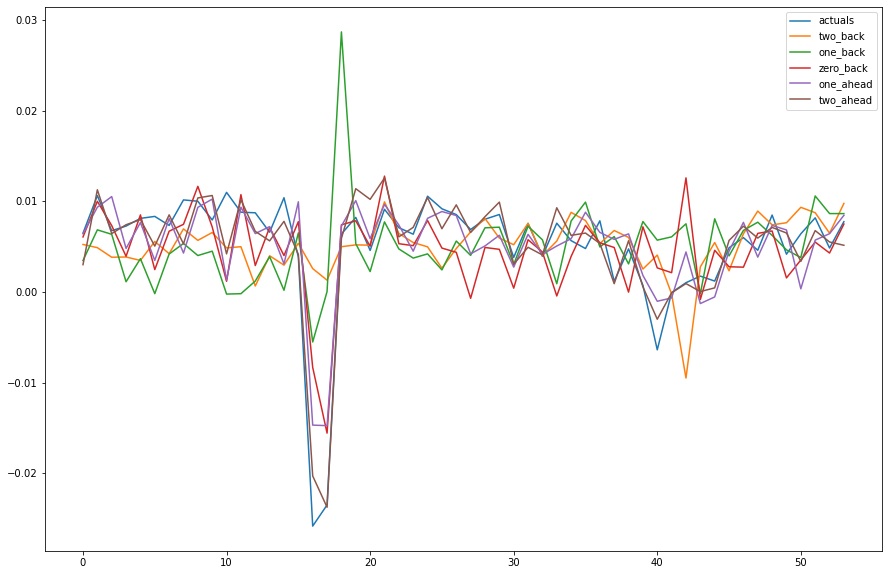

In [16]:
# plot of predictions vs actuals
pd.DataFrame({
    "actuals":actuals, 
    "two_back":pred_dict[-2], 
    "one_back":pred_dict[-1], 
    "zero_back":pred_dict[0],
    "one_ahead":pred_dict[1],
    "two_ahead":pred_dict[2]}
).plot()
;

# Final model usage / getting predictions on new data
Say model selection is finished and the model is to now be used, i.e. used to get predictions on new data.

In [11]:
# the test data ends 2010-12-01, let's say we wanted to predict 2011-03-01
new_data = test.copy()

# the date we want predicted must be in the date, if it's not there it must be added
desired_date = pd.to_datetime("2011-03-01")

while desired_date > np.max(new_data.date):
    new_data.loc[len(new_data), "date"] = np.max(new_data.date) + pd.DateOffset(months=1)

# we can now confirm the date we want to forecast is in the dataframe, even if all values are missing
new_data.tail()

,date,payems,gdpc1,cpiaucsl,unrate,houst,indpro,dspic96,cpilfesl,pcepilfe,pcepi,permit,ulcnfb,a261rx1q020sbea
766,2010-11-01,0.000957,NaN,0.002534,0.042553,0.003683,0.000453,0.000845,0.001438,0.001300,0.001997,0.003584,NaN,NaN
767,2010-12-01,0.000551,0.005196,0.004017,-0.051020,-0.011009,0.009657,0.005819,0.000873,0.000206,0.002263,0.128571,0.001172,0.002461
768,2011-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
769,2011-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
770,2011-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# now transform the data into the appropriate format for the model
transformed_new_data = mean_fill_dataset(new_data, new_data) # we can use the latest data for mean filling, since this isn't for model assessment but inference
transformed_new_data = flatten_data(transformed_new_data, target_variable, 3)

In [13]:
# obtain prediction for the new period
# drop all data but period we're interested in
new_x = transformed_new_data.loc[transformed_new_data.date == "2011-03-01", :].drop(["date", target_variable], axis=1)
model.predict(new_x)[0]

0.00781493206161683